In [4]:
############ LOAD in custom packages ################
import sys
import os
import pandas as pd
import numpy as np
import importlib
from fastdtw import dtw
import seaborn as sns
import matplotlib.pyplot as plt

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path
sys.path.append(project_root)

# Import and reload custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import feature_selection as fs
from scripts import clustering as cl
from scripts import variables as var
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(fs)
importlib.reload(cl)
importlib.reload(var)

################ DEFINE column variables from data ###################
from scripts.variables import id_columns, demographic_columns, daily_cols_v1, daily_v2_common 
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, daily_v2_weather
from scripts.variables import df_names, df_mis, df_names_with_mis
demo_df = pd.read_csv(os.path.join(brighten_dir, f'demographics.csv'))
demographic_vars = [col for col in demo_df.columns if col!='num_id']
print(demographic_vars)
id_columns.append('idx')


['Unnamed: 0', 'phq9_1_base', 'phq9_2_base', 'phq9_3_base', 'phq9_4_base', 'phq9_5_base', 'phq9_6_base', 'phq9_7_base', 'phq9_8_base', 'phq9_9_base', 'phq9_sum_base', 'gender', 'education', 'working', 'income_satisfaction', 'income_lastyear', 'marital_status', 'race', 'age', 'screen_1', 'screen_2', 'screen_3', 'screen_4', 'bipolar', 'scz', 'alc_1', 'alc_2', 'alc_3', 'alc_sum', 'gad7_1', 'gad7_2', 'gad7_3', 'gad7_4', 'gad7_5', 'gad7_6', 'gad7_7', 'gad7_8', 'gad7_sum', 'mhs_1', 'mhs_2', 'mhs_3', 'mhs_4', 'mhs_5', 'mhs_sum', 'bin_clin']


## First, remove skewed variables



For v1_day:
Of 43 measures, 12 measures have skew > 1:
mobility_radius            19.236413
missed_interactions         5.386940
call_duration               4.775961
sms_length                  4.350038
sms_count                   4.152784
aggregate_communication     4.041937
unreturned_calls            3.969245
call_count                  3.086725
mobility                    2.712843
phq9_9                      2.166580
phq9_8                      1.859629
interaction_diversity       1.817821
dtype: float64


For v2_day:
Of 90 measures, 30 measures have skew > 1:
distance_high_speed_transportation               21.268533
hours_high_speed_transportation                  20.133330
hours_high_speed_transportation_hr               19.774562
distance_high_speed_transportation_hr            17.612329
hours_walking_hr                                  8.383335
distance_walking_hr                               7.161692
hours_walking                                     6.726841
distance_walki

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52412/1254109783.py:5: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_trainval.csv'))
/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52412/1254109783.py:5: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_trainval.csv'))
/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52412/1254109783.py:17: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_trainval.csv'))




For v2_day:
Of 90 measures, 23 measures have Kurtosis > 2:
distance_high_speed_transportation               553.936977
hours_high_speed_transportation                  474.228000
hours_high_speed_transportation_hr               455.969698
distance_high_speed_transportation_hr            347.482188
hours_walking_hr                                 126.196577
distance_walking_hr                              113.186892
distance_walking                                  87.147859
hours_walking                                     73.680991
hours_active                                      68.611028
hours_powered_vehicle                             66.779893
precip_sum                                        60.340637
distance_powered_vehicle                          49.983101
distance_active                                   49.294031
distance_powered_vehicle_hr                       34.540720
distance_active_hr                                31.930978
hours_powered_vehicle_hr               

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_52412/1254109783.py:17: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_trainval.csv'))


In [ ]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_trainval.csv'))
    for col in df.columns:
        if col in skewed_cols[name]['skew'] or col in skewed_cols[name]['kurtosis']:
            unskewed_col = 




DATAFRAME: v1_day
In df there are 667 subjects.


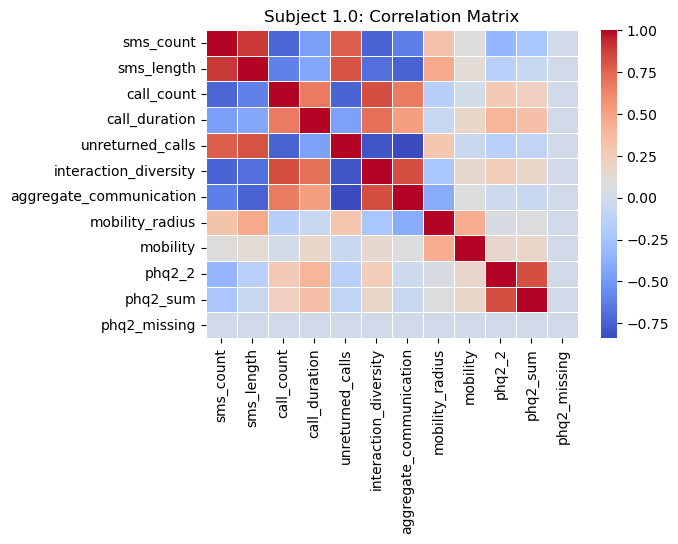

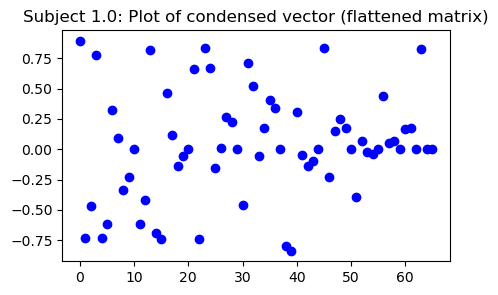

667 subs with symptom matrices
667 filled condensed arrays


In [5]:
#### Take the average of each subject's symptom correlation and use it to make clusters of variables
symptom_matrices_df_dict = {}
flattened_matrices_df_dict = {}
target_cols = phq2_cols+phq9_cols

# Create dicts of all subjects' correlation matrices
for name in ['v1_day']:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_imp_res.csv'))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.loc[:, ~df.columns.str.contains('_int')]
    print(f'\n\nDATAFRAME: {name}')
    ignore_cols = [col for col in df.columns if col in demographic_vars+id_columns or "_indicator" in col or "_bin" in col]
    column_order = ['sms_count','sms_length','call_count','call_duration','unreturned_calls','interaction_diversity','aggregate_communication','mobility_radius','mobility',
                    'phq2_2','phq2_sum','phq2_missing']
    symptom_matrix_dict, flattened_matrix_dict = fs.make_symptom_matrices(df, ignore_cols, num_to_plot=1,column_order=column_order)
    symptom_matrices_df_dict[name] = symptom_matrix_dict
    flattened_matrices_df_dict[name] = flattened_matrix_dict





DATAFRAME: v1_day
In df there are 667 subjects.
667 subs with symptom matrices
667 filled condensed arrays
In df there are 667 subjects.


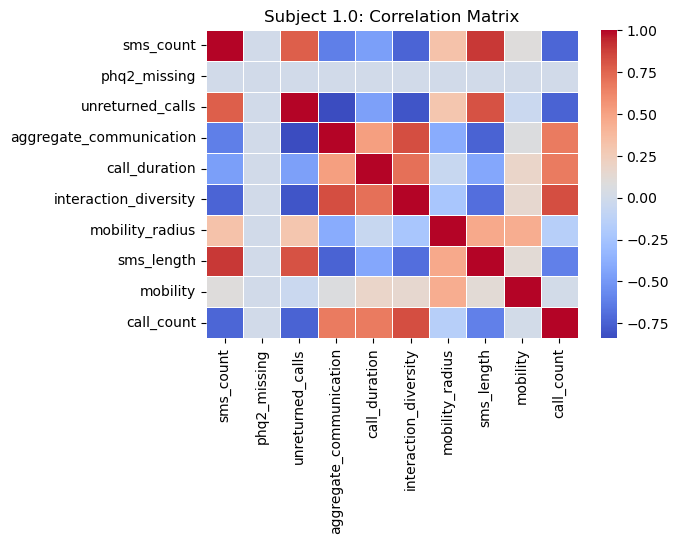

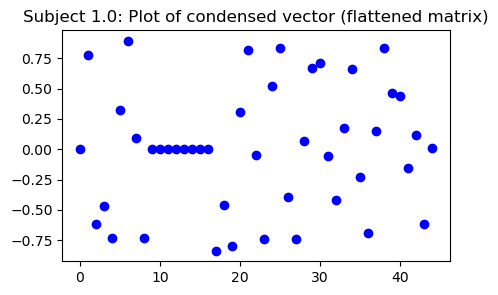

667 subs with symptom matrices
667 filled condensed arrays
In df there are 667 subjects.


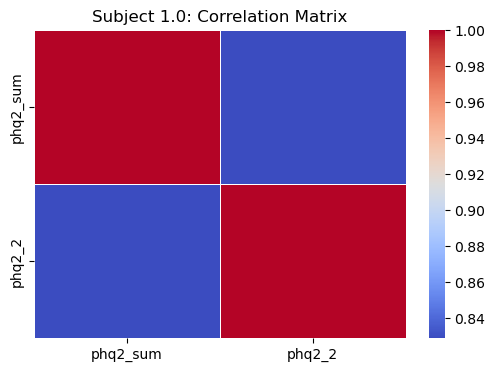

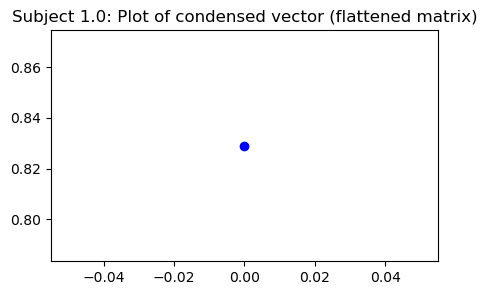

667 subs with symptom matrices
667 filled condensed arrays


DATAFRAME: v2_day
In df there are 294 subjects.
293 subs with symptom matrices
293 filled condensed arrays
In df there are 294 subjects.


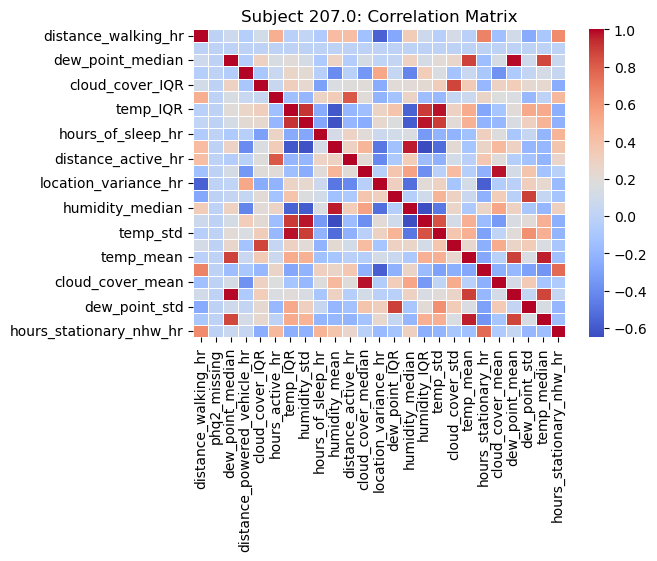

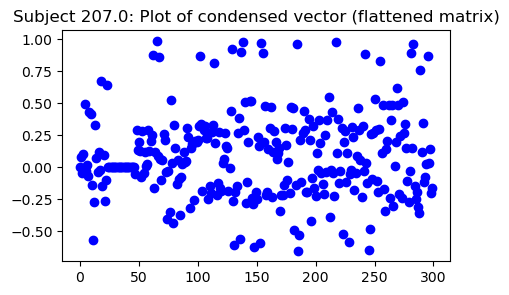

293 subs with symptom matrices
293 filled condensed arrays
In df there are 294 subjects.


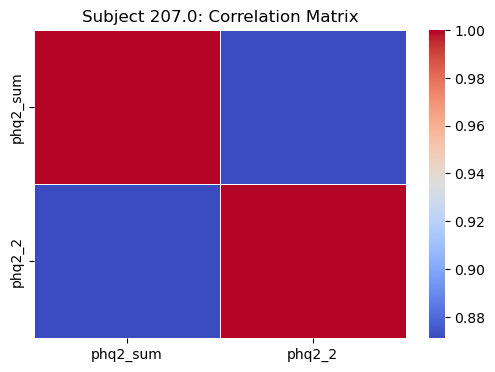

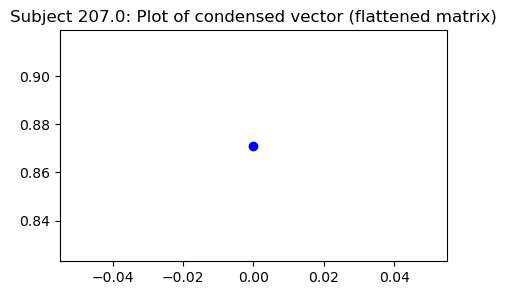

293 subs with symptom matrices
293 filled condensed arrays


DATAFRAME: v1_week
In df there are 572 subjects.
555 subs with symptom matrices
555 filled condensed arrays
In df there are 572 subjects.


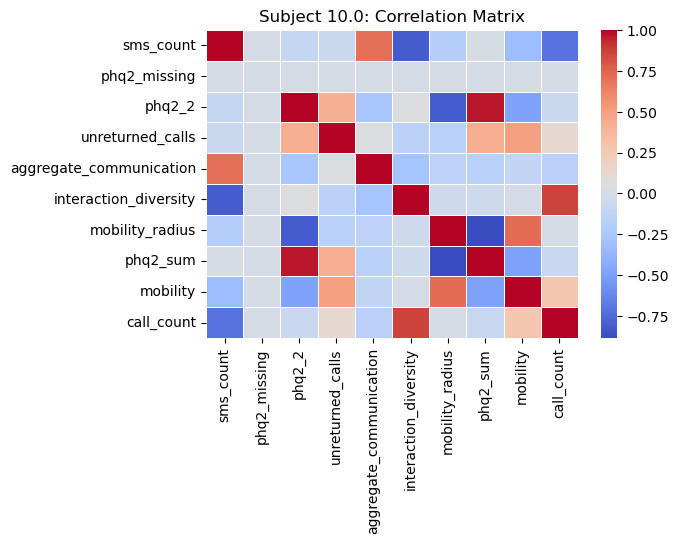

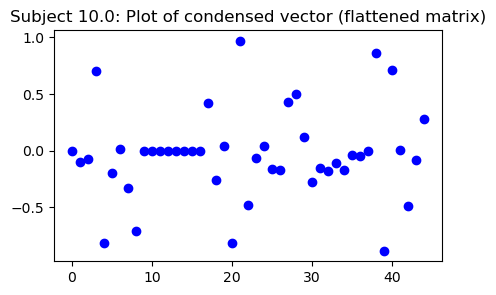

555 subs with symptom matrices
555 filled condensed arrays
In df there are 572 subjects.


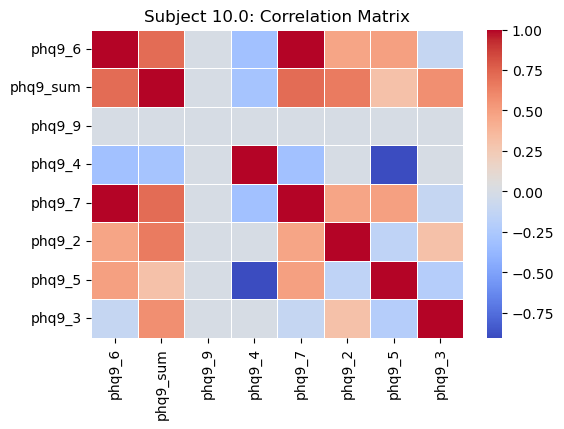

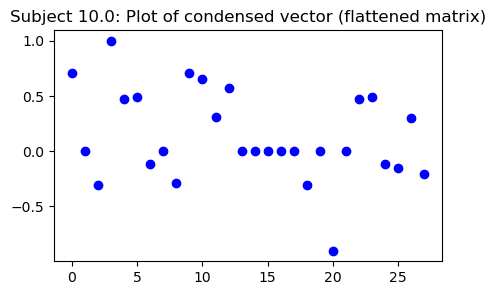

555 subs with symptom matrices
555 filled condensed arrays


DATAFRAME: v2_week
In df there are 239 subjects.
209 subs with symptom matrices
209 filled condensed arrays
In df there are 239 subjects.


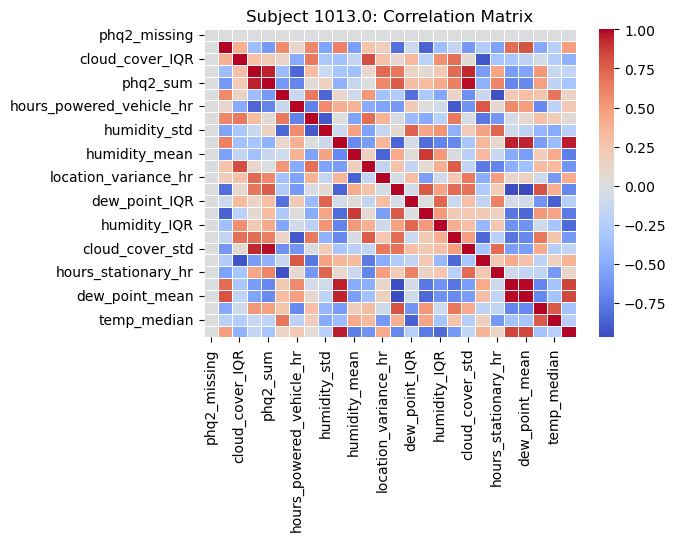

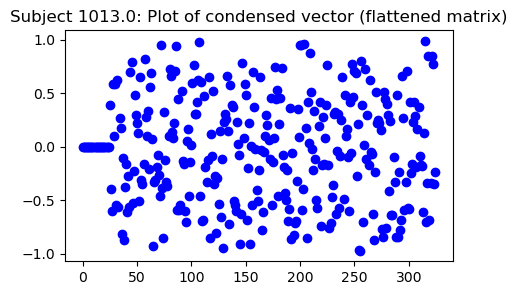

209 subs with symptom matrices
209 filled condensed arrays
In df there are 239 subjects.


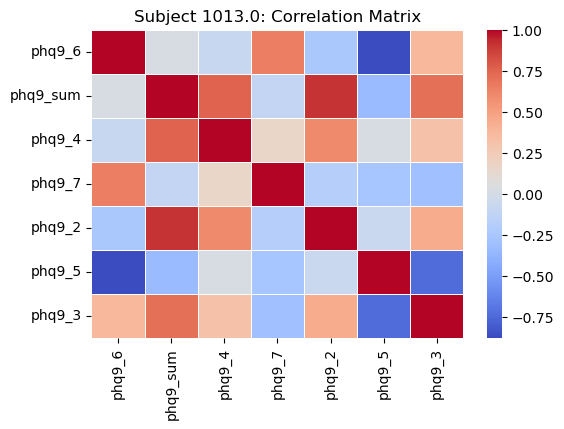

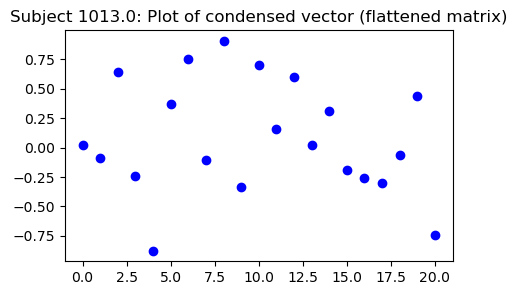

209 subs with symptom matrices
209 filled condensed arrays


In [99]:
#### Take the average of each subject's symptom correlation and use it to make clusters of variables
symptom_matrices_df_dict = {}
flattened_matrices_df_dict = {}
sensor_matrices_df_dict = {}
target_matrices_df_dict = {}
flattened_sensor_df_dict = {}
flattened_target_df_dict = {}

# Create dicts of all subjects' correlation matrices
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_imp_res.csv'))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.loc[:, ~df.columns.str.contains('_int')]
    print(f'\n\nDATAFRAME: {name}')

    # Make symptom/flattened dicts for all cols
    ignore_cols = [col for col in df.columns if col in demographic_vars+id_columns or "_indicator" in col or "_bin" in col]
    symptom_matrix_dict, flattened_matrix_dict = fs.make_symptom_matrices(df, ignore_cols, num_to_plot=0)

    # Assign dicts to nested dict
    symptom_matrices_df_dict[name] = symptom_matrix_dict
    flattened_matrices_df_dict[name] = flattened_matrix_dict


    # Make separate symptom/flattened dicts for target cols vs. sensor cols
    if 'week' in name:
        target_cols = phq9_cols
        sensor_matrices_dict, flattened_sensor_dict = fs.make_symptom_matrices(df, ignore_cols+target_cols, num_to_plot=1)
        non_target_df = df.copy().drop(columns=[col for col in df.columns if col not in target_cols and 'num_id' not in col])
        target_matrices_dict, flattened_target_dict = fs.make_symptom_matrices(non_target_df, ignore_cols, num_to_plot=1)

    if 'day' in name:
        target_cols = phq2_cols
        sensor_matrices_dict, flattened_sensor_dict = fs.make_symptom_matrices(df, ignore_cols+target_cols, num_to_plot=1)
        non_target_df = df.copy().drop(columns=[col for col in df.columns if col not in target_cols and 'num_id' not in col])
        target_matrices_dict, flattened_target_dict = fs.make_symptom_matrices(non_target_df, ignore_cols, num_to_plot=1)

    # Assign sensor/target dicts to nested dict
    sensor_matrices_df_dict[name] = sensor_matrices_dict
    target_matrices_df_dict[name] = target_matrices_dict
    flattened_sensor_df_dict[name] = flattened_sensor_dict
    flattened_target_df_dict[name] = flattened_target_dict
    



/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


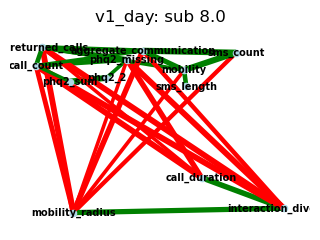

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


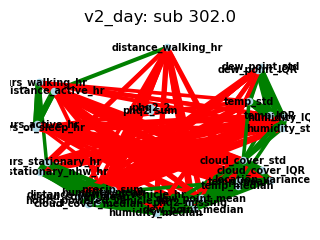

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


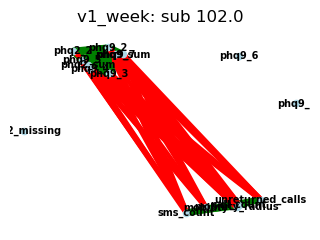

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


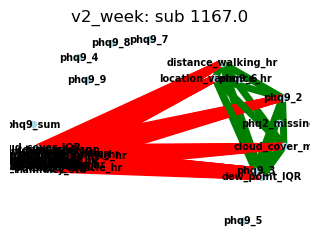

In [27]:
############### Plot individual networks of symptom matrices #################

for name, df_dict in symptom_matrices_df_dict.items():
    count=0
    for sub, corr_matrix in df_dict.items():
        if count<1:
            fs.plot_network(corr_matrix, title=f'{name}: sub {sub}')
            count=+1

In [87]:
# Double check where 'labels' are for columns
symptom_matrices_df_dict['v2_day'][list(symptom_matrices_df_dict['v2_day'].keys())[0]].index

Index(['distance_walking_hr', 'phq2_missing', 'dew_point_median',
       'distance_powered_vehicle_hr', 'cloud_cover_IQR', 'phq2_sum',
       'hours_active_hr', 'temp_IQR', 'humidity_std', 'hours_of_sleep_hr',
       'humidity_mean', 'distance_active_hr', 'cloud_cover_median',
       'location_variance_hr', 'phq2_2', 'dew_point_IQR', 'humidity_median',
       'humidity_IQR', 'temp_std', 'cloud_cover_std', 'temp_mean',
       'hours_stationary_hr', 'cloud_cover_mean', 'dew_point_mean',
       'dew_point_std', 'temp_median', 'hours_stationary_nhw_hr'],
      dtype='object')

### Ok so temp mean and dew point IQR keep having relatively high correlations with the target variables, so we'll keep these, and drop the rest of the weather variables. Humidity also does but since it's highyl correlated with temp, we'll keep it out. 

In [101]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_imp_res.csv'))
    keep = ['temp_mean', 'temp_std', 'dew_point_IQR']
    cols_to_drop = [col for col in df.columns if col in daily_v2_weather and col not in keep]
    print(f"For {name} dropping {cols_to_drop}")
    df2 = df.drop(columns=cols_to_drop)
    df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]  
    df2 = df2.loc[:, ~df2.columns.str.contains('.1')]  
    df_clean = df2.dropna()
    print(f'{name}, Shape of df {df2.shape}, shape of clean df {df_clean.shape}')
    df_clean.to_csv(os.path.join(brighten_dir, f"{name}_dropped-for-pca.csv"))


For v1_day dropping []
v1_day, Shape of df (68424, 33), shape of clean df (68424, 33)
For v2_day dropping ['cloud_cover_mean', 'dew_point_mean', 'humidity_mean', 'humidity_IQR', 'temp_IQR', 'cloud_cover_IQR', 'cloud_cover_std', 'dew_point_std', 'humidity_std', 'cloud_cover_median', 'dew_point_median', 'humidity_median', 'temp_median']
v2_day, Shape of df (21885, 53), shape of clean df (21885, 53)
For v1_week dropping []
v1_week, Shape of df (5157, 50), shape of clean df (5157, 50)
For v2_week dropping ['cloud_cover_mean', 'dew_point_mean', 'humidity_mean', 'humidity_IQR', 'temp_IQR', 'cloud_cover_IQR', 'cloud_cover_std', 'dew_point_std', 'humidity_std', 'cloud_cover_median', 'dew_point_median', 'humidity_median', 'temp_median']
v2_week, Shape of df (1208, 70), shape of clean df (1208, 70)


In [ ]:
#### Take the average of each subject's symptom correlation and use it to make clusters of variables
symptom_matrices_df_dict = {}
flattened_matrices_df_dict = {}
sensor_matrices_df_dict = {}
target_matrices_df_dict = {}
flattened_sensor_df_dict = {}
flattened_target_df_dict = {}

# Create dicts of all subjects' correlation matrices
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_dropped-for-pca.csv'))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.loc[:, ~df.columns.str.contains('_int')]
    print(f'\n\nDATAFRAME: {name}')

    # Make symptom/flattened dicts for all cols
    ignore_cols = [col for col in df.columns if col in demographic_vars+id_columns or "_indicator" in col or "_bin" in col]
    symptom_matrix_dict, flattened_matrix_dict = fs.make_symptom_matrices(df, ignore_cols, num_to_plot=0)

    # Assign dicts to nested dict
    symptom_matrices_df_dict[name] = symptom_matrix_dict
    flattened_matrices_df_dict[name] = flattened_matrix_dict


    # Make separate symptom/flattened dicts for target cols vs. sensor cols
    if 'week' in name:
        target_cols = phq9_cols
        sensor_matrices_dict, flattened_sensor_dict = fs.make_symptom_matrices(df, ignore_cols+target_cols, num_to_plot=0)
        non_target_df = df.copy().drop(columns=[col for col in df.columns if col not in target_cols and 'num_id' not in col])
        target_matrices_dict, flattened_target_dict = fs.make_symptom_matrices(non_target_df, ignore_cols, num_to_plot=0)

    if 'day' in name:
        target_cols = phq2_cols
        sensor_matrices_dict, flattened_sensor_dict = fs.make_symptom_matrices(df, ignore_cols+target_cols, num_to_plot=0)
        non_target_df = df.copy().drop(columns=[col for col in df.columns if col not in target_cols and 'num_id' not in col])
        target_matrices_dict, flattened_target_dict = fs.make_symptom_matrices(non_target_df, ignore_cols, num_to_plot=0)

    # Assign sensor/target dicts to nested dict
    sensor_matrices_df_dict[name] = sensor_matrices_dict
    target_matrices_df_dict[name] = target_matrices_dict
    flattened_sensor_df_dict[name] = flattened_sensor_dict
    flattened_target_df_dict[name] = flattened_target_dict
    





DATAFRAME: v1_day
In df there are 667 subjects.
667 subs with symptom matrices
667 filled condensed arrays
In df there are 667 subjects.
667 subs with symptom matrices
667 filled condensed arrays
In df there are 667 subjects.
667 subs with symptom matrices
667 filled condensed arrays


DATAFRAME: v2_day
In df there are 294 subjects.
293 subs with symptom matrices
293 filled condensed arrays
In df there are 294 subjects.
293 subs with symptom matrices
293 filled condensed arrays
In df there are 294 subjects.
293 subs with symptom matrices
293 filled condensed arrays


DATAFRAME: v1_week
In df there are 572 subjects.
555 subs with symptom matrices
555 filled condensed arrays
In df there are 572 subjects.
555 subs with symptom matrices
555 filled condensed arrays
In df there are 572 subjects.
555 subs with symptom matrices
555 filled condensed arrays


DATAFRAME: v2_week
In df there are 239 subjects.
209 subs with symptom matrices
209 filled condensed arrays
In df there are 239 subjects

# SENSORS PCA

v1_day
(10, 10) variables included


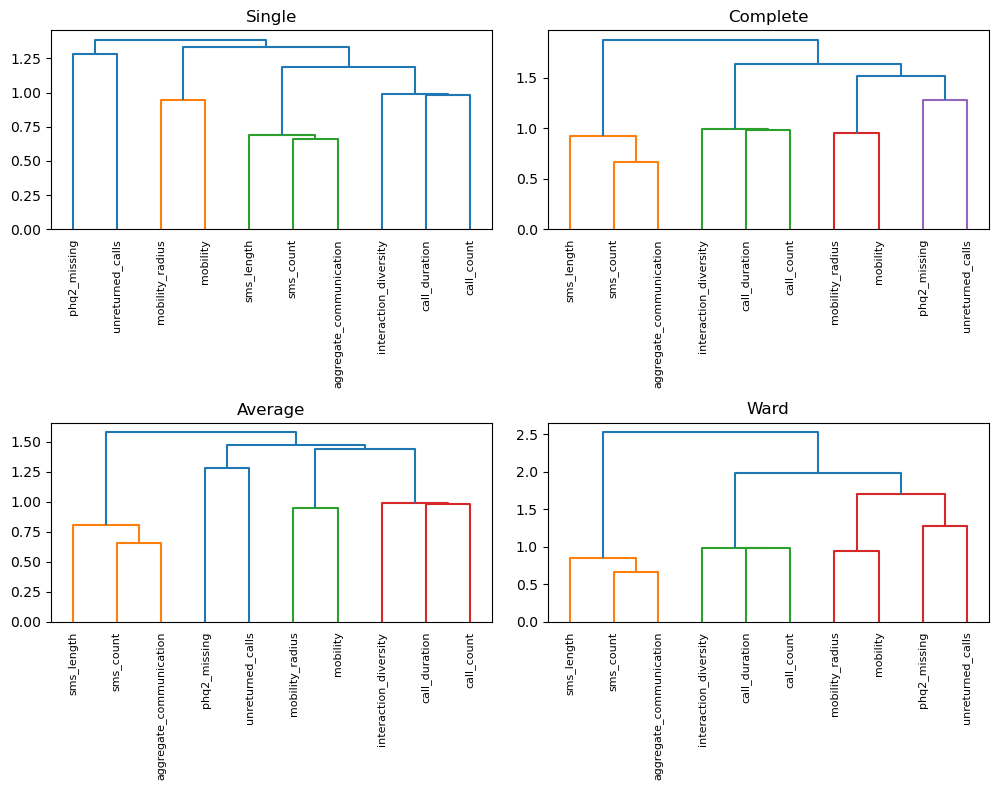

v2_day
(12, 12) variables included


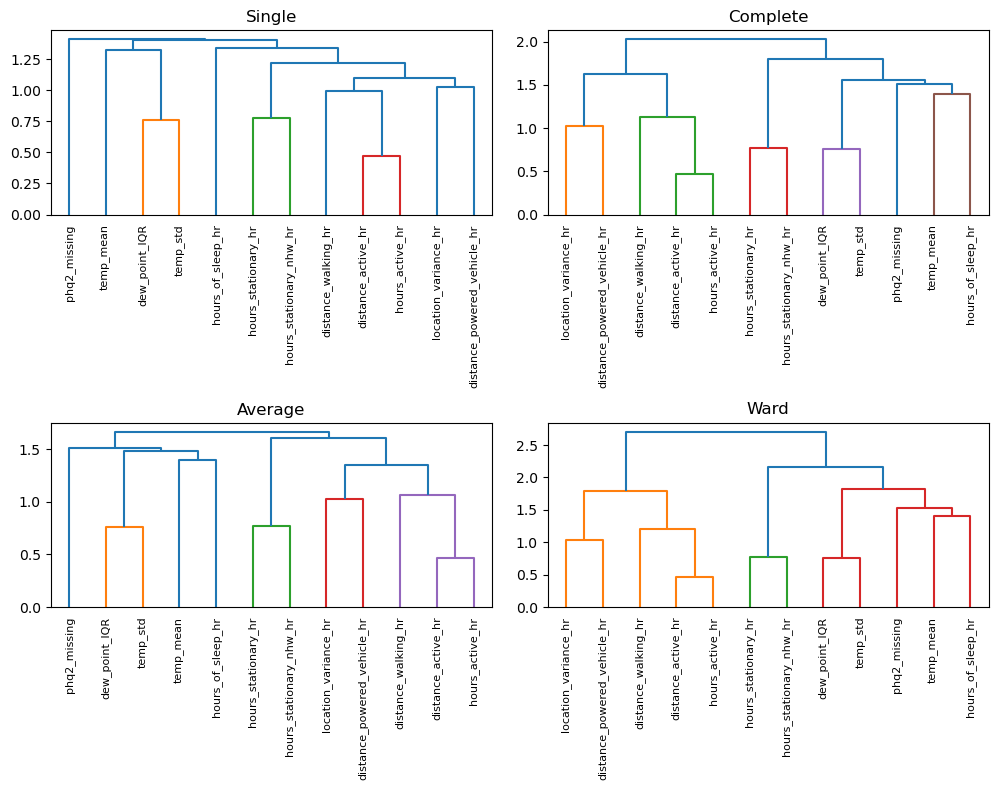

v1_week
(10, 10) variables included


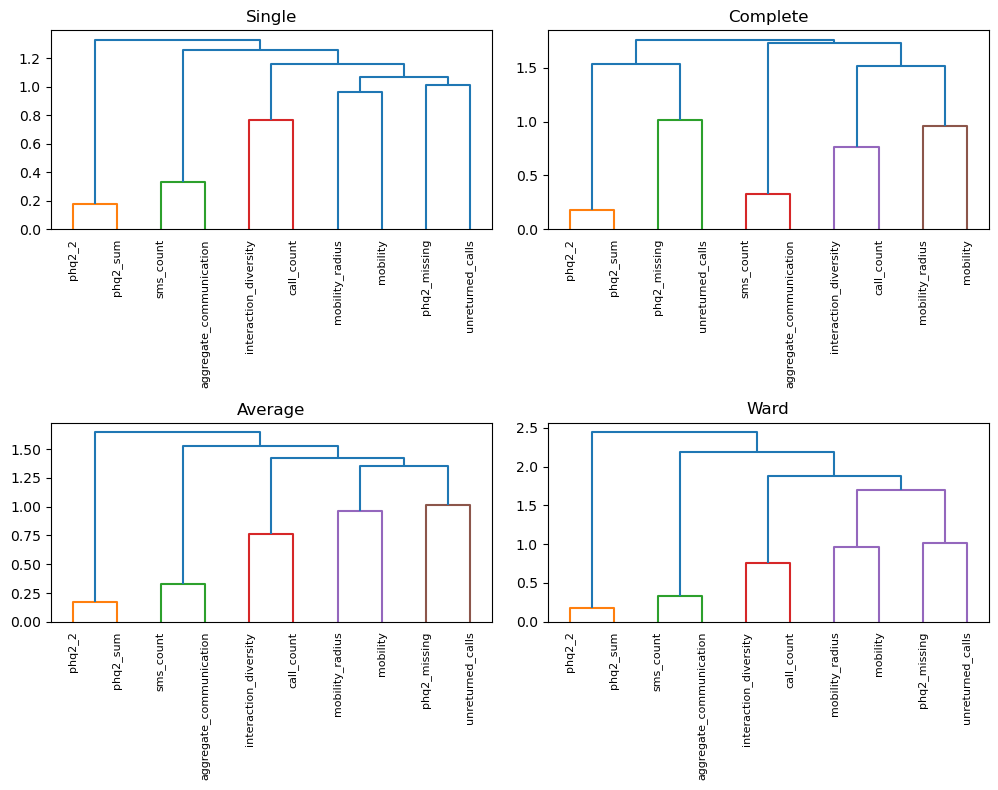

v2_week
(13, 13) variables included


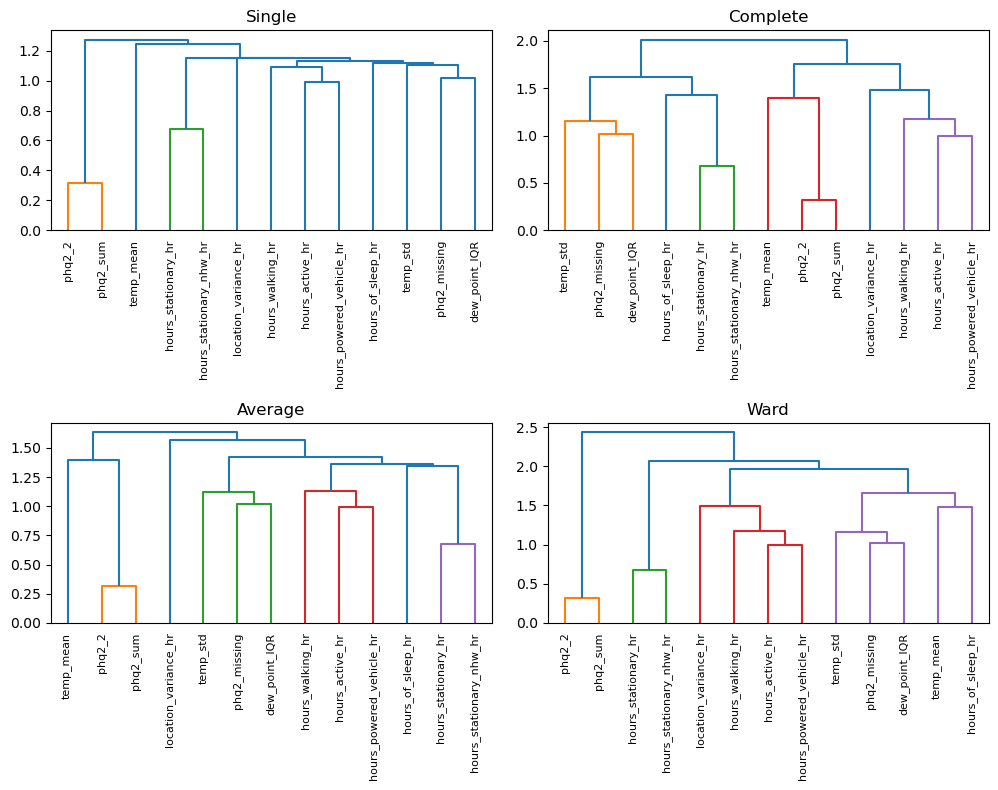

In [104]:
## Plot options
for name, df in sensor_matrices_df_dict.items():
    avg_matrix = fs.average_matrix(df)
    fs.plot_hier_agg(avg_matrix, df[list(df.keys())[0]].index, is_dict=False, group_title=f'{name}') # 3, ward


### Mark down best fits:
* v1_day -> 5, single
* v1_week -> 5, average
* v2_day -> 6, average
* v2_week ->6, average

In [111]:
################# Create cluster_dict of Variables + Cluster Labels ############

sensor_clust_dict = {}
# clust_dict['v1_day'] = v1_day_clust_dict
for name, dictionary in sensor_matrices_df_dict.items():
    avg_matrix = fs.average_matrix(dictionary)
    if 'v1_day' in name:
        sensor_clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=4, linkage='single', is_dict=False)
    if 'v2_day' in name:
       sensor_clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=6, linkage='average', is_dict=False)
    if 'v1_week' in name:
        sensor_clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=5, linkage='complete', is_dict=False)
    if 'v2_week' in name:
       sensor_clust_dict[name] = fs.hier_agg_clustering(avg_matrix, dictionary[list(dictionary.keys())[0]].index, n_clusters=7, linkage='average', is_dict=False)

In [112]:
################# Create df_pca of Variables + 1st PC of clusters Labels ############

dfs_pca = {}
dfs_pca_dict = {}
for name in df_names:
    df_scaled = pd.read_csv(os.path.join(brighten_dir, f'{name}_dropped-for-pca.csv'))
    print(f'\nFor {name}')
    dfs_pca[name], dfs_pca_dict[name] = fs.pca_on_clusters(df_scaled, sensor_clust_dict[name], n_clusters=6) #n_clusters = number shown, so choose max



For v1_day
Cols for cluster 0: ['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'sms_count', 'sms_length']
Cols for cluster 1: ['mobility', 'mobility_radius']
Cols for cluster 2: ['unreturned_calls']
Cols for cluster 3: ['phq2_missing']
Skipping cluster 4: No variables assigned.
Skipping cluster 5: No variables assigned.

For v2_day
Cols for cluster 0: ['distance_walking_hr', 'hours_active_hr', 'distance_active_hr', 'distance_powered_vehicle_hr', 'location_variance_hr']
Cols for cluster 1: ['dew_point_IQR', 'temp_std']
Cols for cluster 2: ['hours_stationary_hr', 'hours_stationary_nhw_hr']
Cols for cluster 3: ['phq2_missing']
Cols for cluster 4: ['hours_of_sleep_hr']
Cols for cluster 5: ['temp_mean']

For v1_week
Cols for cluster 0: ['phq2_missing', 'unreturned_calls']
Cols for cluster 1: ['mobility', 'mobility_radius']
Cols for cluster 2: ['aggregate_communication', 'sms_count']
Cols for cluster 3: ['phq2_2', 'phq2_sum']
Cols for cluster 4: ['call_co

In [107]:
# # Name the clusters
dfs_pca_dict['v1_day'][0]['name'] = 'pc_communications'
dfs_pca_dict['v1_day'][1]['name'] = 'pc_mobility'
dfs_pca_dict['v1_day'][2]['name'] = 'pc_unreturned_calls'
dfs_pca_dict['v1_day'][3]['name'] = 'pc_phq2_missing'

dfs_pca_dict['v2_day'][0]['name'] = 'pc_active'
dfs_pca_dict['v2_day'][1]['name'] = 'pc_temp-std'
dfs_pca_dict['v2_day'][2]['name'] = 'pc_stationary'
dfs_pca_dict['v2_day'][3]['name'] = 'pc_phq2_missing'
dfs_pca_dict['v2_day'][4]['name'] = 'pc_hours_of_sleep'
dfs_pca_dict['v2_day'][5]['name'] = 'pc_temp'

dfs_pca_dict['v1_week'][0]['name'] = 'pc_missing'
dfs_pca_dict['v1_week'][1]['name'] = 'pc_mobility'
dfs_pca_dict['v1_week'][2]['name'] = 'pc_communications'
dfs_pca_dict['v1_week'][3]['name'] = 'pc_phq2'
dfs_pca_dict['v1_week'][4]['name'] = 'pc_calls'

dfs_pca_dict['v2_week'][0]['name'] = 'pc_active'
dfs_pca_dict['v2_week'][1]['name'] = 'pc_temp-std'
dfs_pca_dict['v2_week'][2]['name'] = 'pc_stationary'
dfs_pca_dict['v2_week'][3]['name'] = 'pc_phq2'
dfs_pca_dict['v2_week'][4]['name'] = 'pc_temp'
dfs_pca_dict['v2_week'][5]['name'] = 'pc_location-variance'


for name in df_names:
    df_scaled = pd.read_csv(os.path.join(brighten_dir, f'{name}_imp_res.csv'))
    dfs_pca[name] = fs.merge_df_via_cluster_pca_dict(df_scaled, dfs_pca_dict[name], on_columns=['num_id', 'dt', 'week'])
    dfs_pca[name].to_csv(os.path.join(brighten_dir, f'{name}_pca.csv'), index=False)




/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


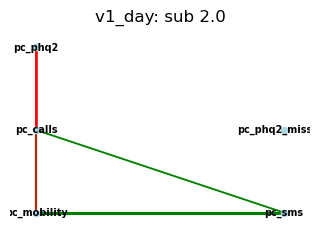

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


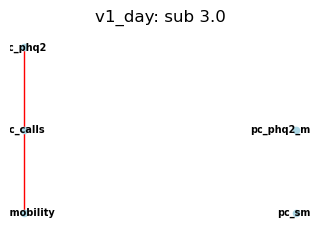

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


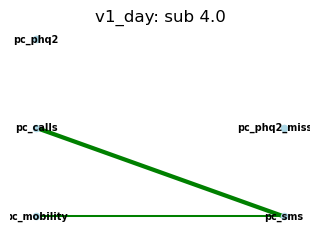

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


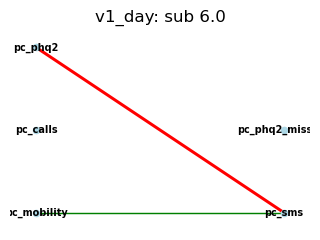

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


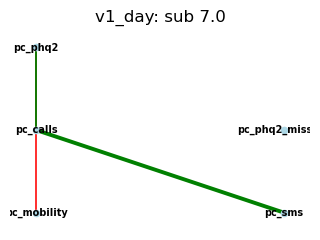

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


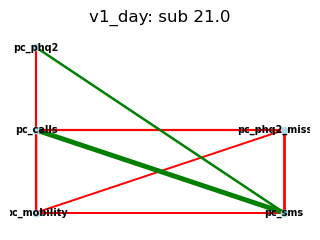

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


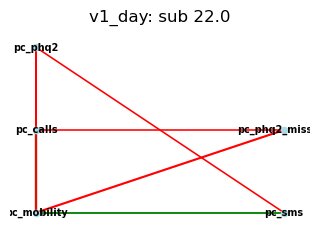

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


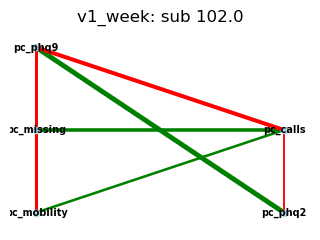

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


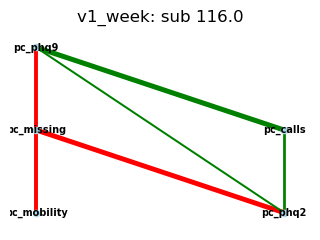

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


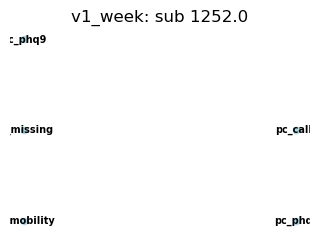

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


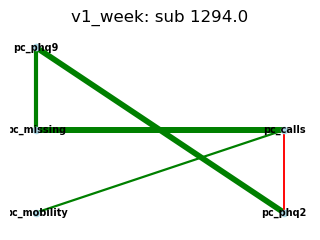

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


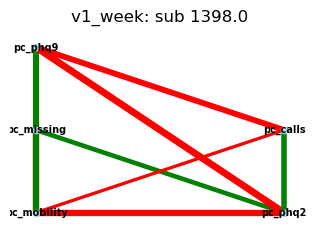

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


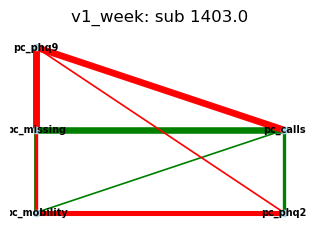

/Users/demo/Library/CloudStorage/Box-Box/Holmes_lab_kaley/motif_proj/smartphone_sensor_predictive_modeling/scripts/feature_selection.py:377: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


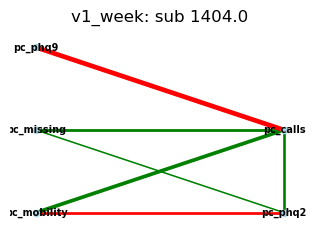

In [18]:
############ Plot subjects' individual networks of PCs ############

# Predefine fixed positions for nodes
fixed_positions_v1_day = {
    'pc_mobility': (1, 1),
    'pc_calls': (1, 2),
    'pc_sms': (2, 1),
    'pc_phq2': (1, 3),
    'pc_phq2_missing': (2, 2)
}

fixed_positions_v1_week = {
    'pc_missing': (1, 2),
    'pc_mobility': (1, 1),
    'pc_phq2': (2, 1),
    'pc_phq9': (1, 3),
    'pc_calls': (2, 2)
}


for name, df in dfs_pca.items():
    count, count2 = 0, 0
    
    cols=[col for col in df.columns.to_list() if 'pc_' in col]
    for sub in df['num_id'].unique():
        sub_df = df[df['num_id']==sub]
        if sub_df.shape[0] > 8:
            if count<7:
                if 'v1_day' in name:
                    fs.plot_network(sub_df, cols, title=f'{name}: sub {sub}', threshold=0.2, fixed_positions=fixed_positions_v1_day)
                    count+=1
            if count2<7:
                if 'v1_week' in name:
                    fs.plot_network(sub_df, cols, title=f'{name}: sub {sub}', threshold=0.2, fixed_positions=fixed_positions_v1_week)
                    count2+=1


## Checking for collinearity




For v1_day:


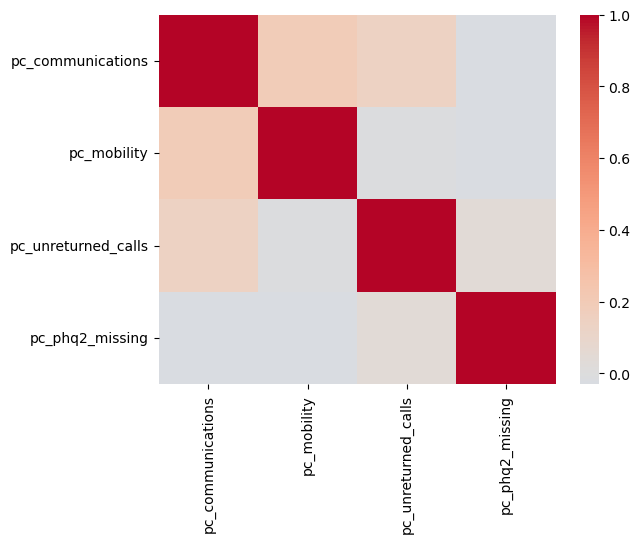



For v2_day:


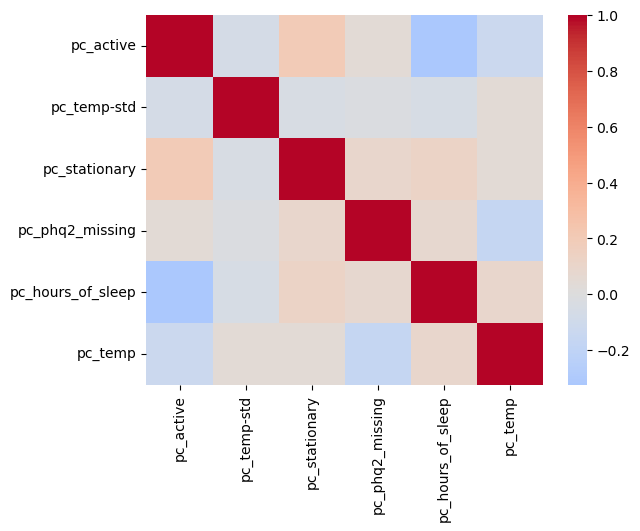



For v1_week:


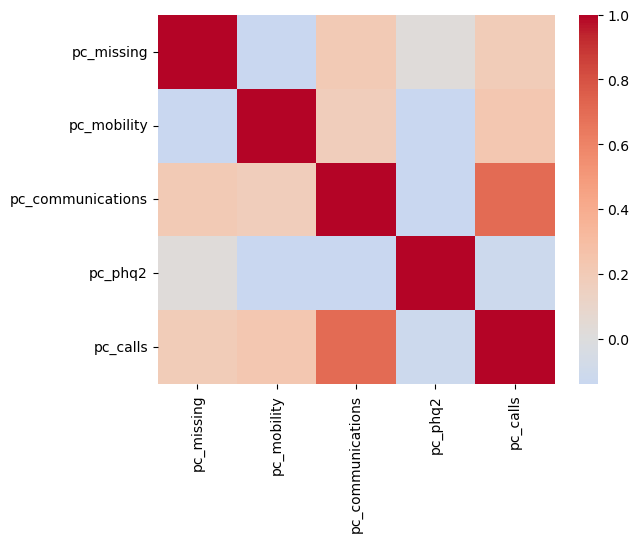



For v2_week:


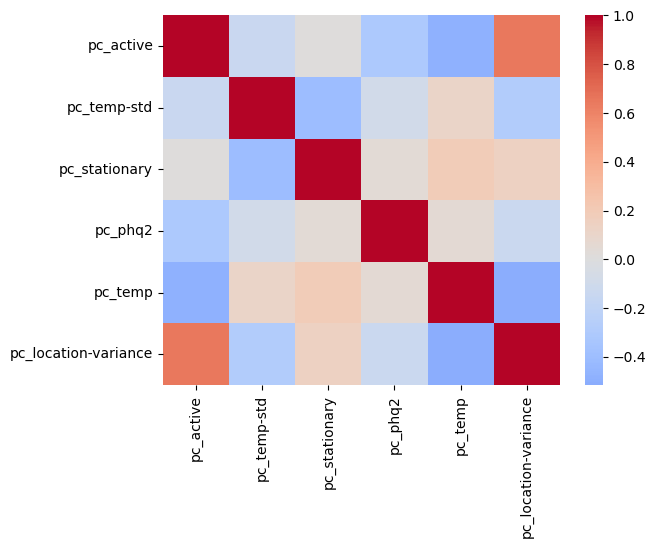

In [117]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if 'pc_' in col]
    sns.heatmap(df[numeric_cols].corr(), cmap="coolwarm", center=0)
    plt.show()

We can see that our features are successfull not correlated, except phq2 and phq9, which is expected, and in most cases, phq2 won't be used to predict phq9. 

In [59]:
# for name in df_names:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
#     print(f'\n\nFor {name}:')
#     numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
#     print('\nInvestigating Kurtosis:')
#     # Calculate kurtosis for numeric columns
#     kurtosis_values = df[numeric_cols].select_dtypes(include='number').apply(lambda x: kurtosis(x, fisher=True))
#     kurtosis_sorted = kurtosis_values.sort_values(ascending=False) # Sort by highest kurtosis
#     print(kurtosis_sorted) #display
    
#     for col in kurtosis_sorted.isna().index:
#         print(f'Kurtosis is NaN for {col}:')
#         print(df[col].nunique())      # Unique values
#         print(df[col].isna().sum())   # Missing values
#         print(df[col].describe())     # Summary stats


In [58]:
# for name in df_names:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
#     print(f'\n\nFor {name}:')
#     numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
#     print('\nInvestigating skew:')
#     print(df[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)) # sort by highest, display    

In [ ]:
# ### Create lag variable
# for name in df_names:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
#     print(f'\n\nFor {name}:')
#     lag = phq9_cols + phq2_cols
#     to_lag = [col for col in lag if col in df.columns]
#     df_lag = pre.create_lag_variables(df, to_lag)
#     df_lag.to_csv(os.path.join(brighten_dir, f'{name}_pca_lag.csv'), index=False)
#     print(f"Saved {name}_pca_lag.csv to brighten_dir")





FOR v1_day, target_var: phq2_sum


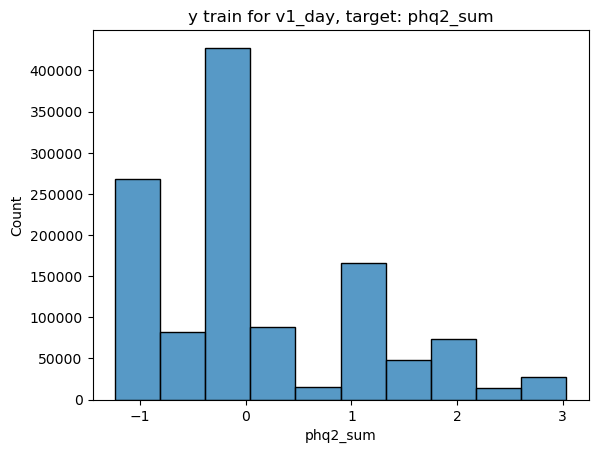

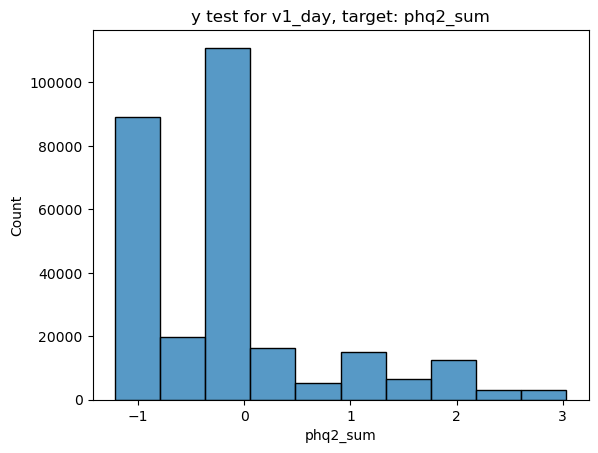



FOR v2_day, target_var: phq2_sum


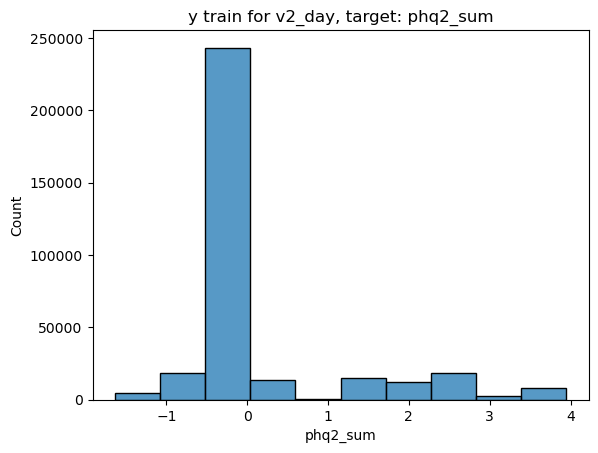

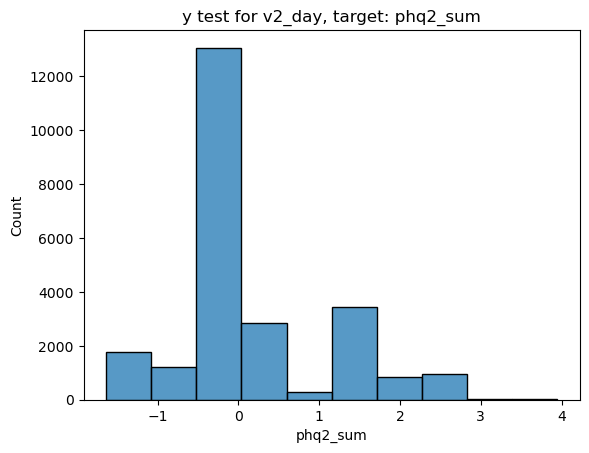



FOR v1_week, target_var: phq9_sum


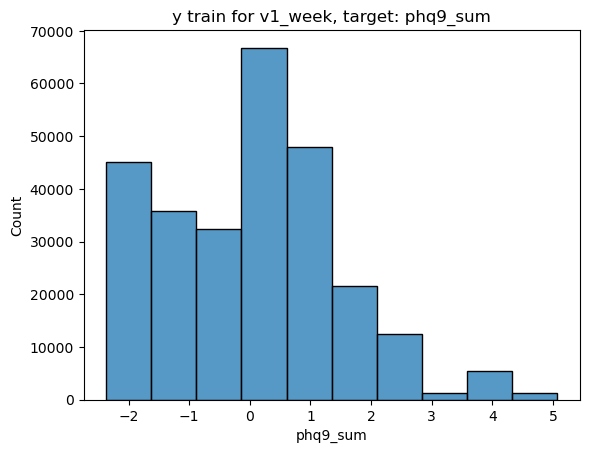

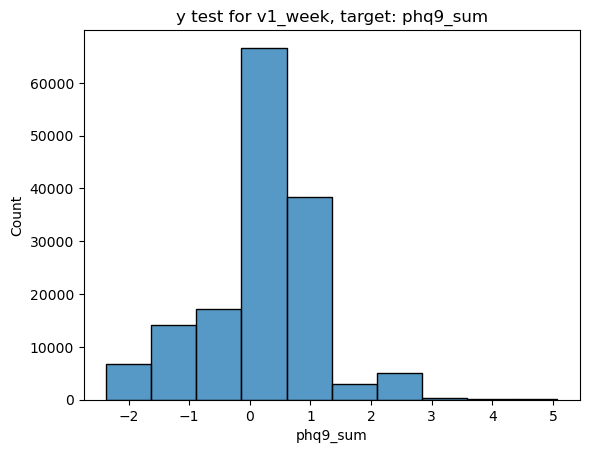



FOR v2_week, target_var: phq9_sum


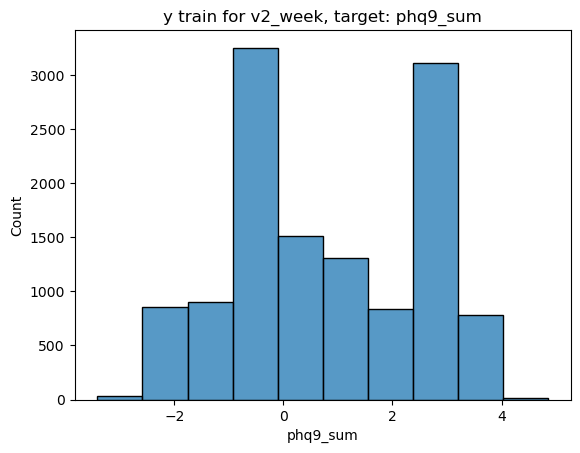

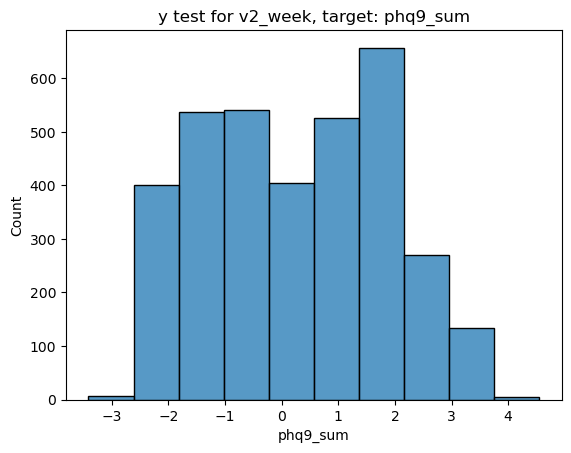

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

for name in df_names:
    data_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_pca.csv'))
    data_df = data_df.dropna()
    if not data_df.empty:
        if 'phq9_sum' in data_df.columns:
            target_var = 'phq9_sum'
        else:
            target_var = 'phq2_sum'
        print(f"\n\nFOR {name}, target_var: {target_var}")

        X = data_df.drop(columns=[col for col in data_df.columns if 'phq9' in col or 'phq2' in col]).copy()
        y = data_df[target_var].copy()

        gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
        groups = data_df['num_id'] # groups variable is based on num_id, so that no subjects are in train and test etc, 
        trainval_idx, test_idx = next(gss.split(X, y, groups=groups))

        # Get train/test sets
        X_trainval, X_test = X.iloc[trainval_idx], X.iloc[test_idx]
        y_trainval, y_test = y.iloc[trainval_idx], y.iloc[test_idx]

        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        groups_trainval = groups.iloc[trainval_idx]  # redefining groups to only include subs in traintest df
        train_idx, val_idx = next(gss.split(X_trainval, y_trainval, groups=groups_trainval))

        # Get train/test sets
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_test.to_csv(os.path.join(brighten_dir, f'{name}_pca_X_test.csv'))
        y_test.to_csv(os.path.join(brighten_dir, f'{name}_pca_y_test.csv'))
        X_train.to_csv(os.path.join(brighten_dir, f'{name}_pca_X_train.csv'))
        y_train.to_csv(os.path.join(brighten_dir, f'{name}_pca_y_train.csv'))
        X_val.to_csv(os.path.join(brighten_dir, f'{name}_pca_X_val.csv'))
        y_val.to_csv(os.path.join(brighten_dir, f'{name}_pca_y_val.csv'))


        # # Create hisogram for target value
        # sns.histplot(y_val, bins=10)
        # plt.title(f'y val for {name}, target: {target_var}')
        # plt.show()

        # Create hisogram for target value
        sns.histplot(y_train, bins=10)
        plt.title(f'y train for {name}, target: {target_var}')
        plt.show()

        # Create hisogram for target value
        sns.histplot(y_test, bins=10)
        plt.title(f'y test for {name}, target: {target_var}')
        plt.show()
